In this notebook, we will examine the Kaggle House Prices data (https://www.kaggle.com/c/house-prices-advanced-regression-techniques) using scikit-learn and xgboost. We begin by importing libraries and setting some display options:

In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
from xgboost import XGBRegressor
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 100)

We will divide the Kaggle-supplied training data into a training set and our own test set. We will use our hold-out test set to compute the generalization error from our final model. The alternative would have been to use nested cross-validation, but by splitting we are also able to avoid overfitting through our examination of the descriptives. At the end, we will re-fit our final model on all the training data prior to computing our submission predictions.

In [33]:
data = pd.read_csv('train.csv')
train_orig, test = train_test_split(data, test_size=0.2)
train_orig.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1168.000000,1168.000000,1168,969.000000,1168.000000,1168,70,1168,1168,1168,1168,1168,1168,1168,1168,1168,1168,1168.000000,1168.000000,1168.000000,1168.000000,1168,1168,1168,1168,1160,1160.000000,1168,1168,1168,1137,1137,1136,1137,1168.000000,1136,1168.000000,1168.000000,1168.000000,1168,1168,1168,1167,1168.00000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168,1168.000000,1168,1168.000000,627,1106,1106.000000,1106,1168.000000,1168.000000,1106,1106,1168,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,7,222,41,1168.000000,1168.000000,1168.000000,1168,1168,1168.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,4,4,6,NaN,6,NaN,NaN,NaN,5,5,2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,6,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,TA,No,Unf,NaN,Unf,NaN,NaN,NaN,GasA,Ex,Y,SBrkr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,929,NaN,NaN,1162,40,733,1046,1167,850,1106,182,1006,1155,983,569,NaN,NaN,NaN,NaN,922,1149,409,402,686,NaN,723,1029,516,520,1050,767,339,NaN,1004,NaN,NaN,NaN,1143,586,1090,1061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,586,NaN,1088,NaN,309,696,NaN,485,NaN,NaN,1048,1064,1072,NaN,NaN,NaN,NaN,NaN,NaN,3,123,37,NaN,NaN,NaN,1008,950,NaN
mean,730.421233,56.515411,NaN,70.655315,10407.940068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.123288,5.577055,1971.202055,1984.718322,NaN,NaN,NaN,NaN,NaN,106.629310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,446.180651,NaN,45.125000,564.044521,1055.350171,NaN,NaN,NaN,NaN,1162.44863,359.245719,5.020548,1526.714897,0.426370,0.057363,1.572774,0.398116,2.874144,1.047945,NaN,6.541952,NaN,0.619863,NaN,NaN,1978.387884,NaN,1.774829,475.943493,NaN,NaN,NaN,95.934075,47.184932,22.073630,3.507705,14.952911,3.448630,NaN,NaN,NaN,43.231164,6.300514,2007.814212,NaN,NaN,182072.145548
std,426.469481,41.600558,NaN,24.875535,7984.841234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.378077,1.131108,30.209442,20.643718,NaN,NaN,NaN,NaN,NaN,183.636454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,461.855628,NaN,158.389998,442.063640,445.900671,NaN,NaN,NaN,NaN,388.50376,441.549599,44.221317,531.122623,0.518441,0.236289,0.549062,0.508603,0.818854,0.225448,NaN,1.636648,NaN,0.638134,NaN,NaN,24.768733,NaN,0.745038,213.978717,NaN,NaN,NaN,128.014044,65.789934,62.450801,28.330887,55.875369,44.896939,NaN,NaN,NaN,537.607765,2.698109,1.335266,NaN,NaN,79373.775531
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,334.00000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,1900.000000,NaN,0.000000,

There are a large number of features. Because our main interest here is in experimenting with regression techniques, we will focus on key features where we have a good level of variation, and recode them so as to avoid small cell sizes that could lead to overfitting.

In [34]:
def preprocess(df):
    keep_columns = ['Id', 'BedroomAbvGr', 'FullBath', 'HalfBath', 'GrLivArea',
            'MSZoning', 'Neighborhood', 'Condition1',
            'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
            'ExterQual', 'ExterCond', 'BsmtQual',
            'HeatingQC', 'CentralAir', 'KitchenQual',
            'Fireplaces', 'GarageCars', 'YrSold',]
    if 'SalePrice' in df.columns: keep_columns += ['SalePrice']
    df = df.copy()
    df = df[keep_columns]
    df['GrLivArea'] = df['GrLivArea'].astype(np.float64)
    
    df['BedroomAbvGr'] = pd.cut(df['BedroomAbvGr'], [0, 1, 2, 3, 10], right=True)
    df['Bath'] = df['FullBath'] + df['HalfBath']
    del df['FullBath']
    del df['HalfBath']
    df['Bath'] = pd.cut(df['Bath'], [-1, 1, 2, 10], right=True)
    df.loc[-df['MSZoning'].isin(['RL', 'RM']), 'MSZoning'] = 'Other'
    df.loc[-df['Neighborhood'].isin(['NAmes', 'CollgCr', 'OldTown', 'Edwards',
                                      'Somerst', 'Gilbert', 'NridgHt', 'NWAmes',
                                      'Sawyer', 'BrkSide']), 'Neighborhood'] = 'Other'
    df['Condition1'] = df['Condition1'].replace(['Norm', 'PosN', 'PosA',], 'Norm/Pos')
    df['Condition1'] = df['Condition1'].replace(['Feedr', 'Artery', 'RRAn', 'RRAe',
                                                'RRNn', 'RRNe',], 'Road/RR')
    df['BldgType'] = df['BldgType'].replace(['2fmCon', 'Duplex',], '2Fam')
    df['BldgType'] = df['BldgType'].replace(['TwnhsE', 'TwnhsI',], 'Twnhs')
    df['HouseStyle'] = df['HouseStyle'].replace('1.5Unf', '1Story')
    df['HouseStyle'] = df['HouseStyle'].replace(['2.5Unf', '2.5Fin'], '2Story')
    df['HouseStyle'] = df['HouseStyle'].replace('SFoyer', 'SLvl')
    df['OverallQual_cat'] = pd.cut(df['OverallQual'], [0, 4, 5, 6, 7, 10], right=True)
    del df['OverallQual']
    df['OverallCond_cat'] = pd.cut(df['OverallCond'], [0, 4, 5, 6, 7, 10], right=True)
    del df['OverallCond']
    df['YearBuilt_cat'] = pd.cut(df['YearBuilt'], [1800, 1929, 1949, 1959, 1969, 1979,
                                                   1995, 2000, 2005, 2015], right=True)
    del df['YearBuilt']
    df['ExterQual'] = df['ExterQual'].replace(['Po', 'Fa', 'TA'], 'Po/Fa/TA')
    df['ExterCond'] = df['ExterCond'].replace(['Po', 'Fa', 'TA'], 'Po/Fa/TA')
    df['ExterCond'] = df['ExterCond'].replace(['Gd', 'Ex'], 'Gd/Ex')
    df['BsmtQual'] = df['BsmtQual'].replace(['Po', 'Fa', 'TA'], 'Po/Fa/TA')
    df['BsmtQual'] = df['BsmtQual'].replace(np.nan, 'NA')
    df['HeatingQC'] = df['HeatingQC'].replace(['Po', 'Fa'], 'Po/Fa')
    df['KitchenQual'] = df['KitchenQual'].replace(['Po', 'Fa', 'TA'], 'Po/Fa/TA')
    df['Fireplace'] = (df['Fireplaces'] > 0).astype(np.uint8)
    del df['Fireplaces']
    df.loc[df['GarageCars'] > 3, 'GarageCars'] = 3
    assert not (df['YrSold'] < 2006).any()
    assert not (df['YrSold'] > 2010).any()
    
    dummies = [('BedroomAbvGr', 4), ('Bath', 3), 
               ('MSZoning', 3), ('Neighborhood', 11),
              ('Condition1', 2), ('BldgType', 3), ('HouseStyle', 4), ('OverallQual_cat', 5),
              ('OverallCond_cat', 5), ('YearBuilt_cat', 9), ('ExterQual', 3),
              ('ExterCond', 2), ('BsmtQual', 4), ('HeatingQC', 4),
               ('CentralAir', 2), ('KitchenQual', 3),
               ('GarageCars', 4), ('YrSold', 5),]
    for dummy, num_values in dummies:
        assert len(df[dummy].value_counts()) == num_values
        df = pd.concat([df, pd.get_dummies(df[dummy], prefix=dummy)], axis=1)
        del df[dummy]
    
    return df
train = preprocess(train_orig)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 789 to 1201
Data columns (total 80 columns):
Id                            1168 non-null int64
GrLivArea                     1168 non-null float64
SalePrice                     1168 non-null int64
Fireplace                     1168 non-null uint8
BedroomAbvGr_(0, 1]           1168 non-null uint8
BedroomAbvGr_(1, 2]           1168 non-null uint8
BedroomAbvGr_(2, 3]           1168 non-null uint8
BedroomAbvGr_(3, 10]          1168 non-null uint8
Bath_(-1, 1]                  1168 non-null uint8
Bath_(1, 2]                   1168 non-null uint8
Bath_(2, 10]                  1168 non-null uint8
MSZoning_Other                1168 non-null uint8
MSZoning_RL                   1168 non-null uint8
MSZoning_RM                   1168 non-null uint8
Neighborhood_BrkSide          1168 non-null uint8
Neighborhood_CollgCr          1168 non-null uint8
Neighborhood_Edwards          1168 non-null uint8
Neighborhood_Gilbert          1168 non-

To begin working with the data, we fit a decision tree. A maximum depth of 5 seems to work fairly well. Reassuringly, the fitted decision tree makes sense intuitively, placing high weight on overall material and finish of the house and living area, and associating higher prices with better quality and more living area.

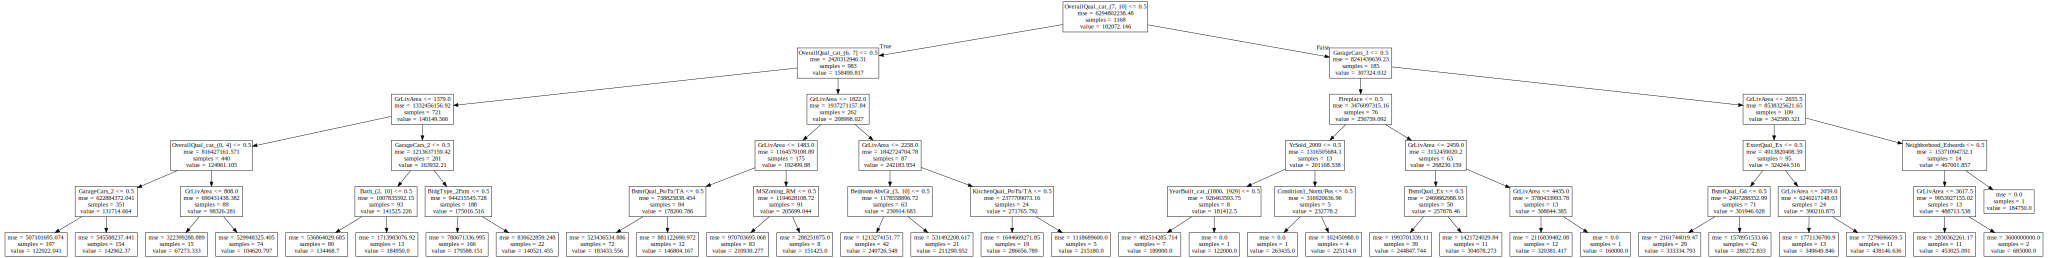

In [35]:
feature_names = list(train.drop(['Id', 'SalePrice'], axis=1).columns)

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if 'SalePrice' in X.columns:
            return X.drop(['SalePrice', 'Id'], axis=1).values
        else:
            return X.drop('Id', axis=1).values

dtree_pipe = Pipeline([
    ('selector', DataFrameSelector()),
    ('dtree', DecisionTreeRegressor(max_depth=5)),
])
dtree_pipe.fit(train, train['SalePrice'])
dot_data = export_graphviz(dtree_pipe.named_steps['dtree'], out_file=None,
                           feature_names=feature_names)
graphviz.Source(dot_data)

Even after winnowing down, we still have a large number of features, so we next perform some feature selection to reduce the dimensionality of the data. As the decision tree above seemed to be giving reasonable results, we will try using an extra-trees regressor to estimate feature importances.

In [36]:
etree_pipe = Pipeline([
    ('selector', DataFrameSelector()),
    ('etree', ExtraTreesRegressor())
])
etree_pipe.fit(train, train['SalePrice'])
importances = etree_pipe.named_steps['etree'].feature_importances_
print('Mean feature importance: {0:>20.4f}'.format(np.mean(importances)))
print('Median feature importance: {0:>18.4f}'.format(np.median(importances)))
print('{0:30} {1:10}'.format('Feature', 'Importance'))
printlnmean = True
printlnmedian = True
for i, importance in sorted(enumerate(importances), key=lambda x: -x[1]):
    if importance < np.mean(importances) and printlnmean:
        print('-'*80)
        printlnmean = False
    if importance < np.median(importances) and printlnmedian:
        print('-'*80)
        printlnmedian = False
    print('{0:30} {1:10.4f}'.format(feature_names[i], importance))
model = SelectFromModel(etree_pipe.named_steps['etree'], prefit=True, threshold='median')
X_new = model.transform(train.drop(['Id', 'SalePrice'], axis=1))
X_new.shape

Mean feature importance:               0.0128
Median feature importance:             0.0018
Feature                        Importance
OverallQual_cat_(7, 10]            0.4691
OverallQual_cat_(6, 7]             0.1239
GrLivArea                          0.0669
GarageCars_3                       0.0503
GarageCars_2                       0.0284
BsmtQual_Gd                        0.0258
Fireplace                          0.0211
--------------------------------------------------------------------------------
Bath_(2, 10]                       0.0126
BedroomAbvGr_(2, 3]                0.0121
OverallQual_cat_(0, 4]             0.0113
ExterQual_Ex                       0.0110
MSZoning_RM                        0.0110
YearBuilt_cat_(1995, 2000]         0.0107
YrSold_2007                        0.0089
Neighborhood_Edwards               0.0071
Neighborhood_Other                 0.0063
YearBuilt_cat_(2000, 2005]         0.0057
YrSold_2009                        0.0055
BsmtQual_Ex                  

(1168, 39)

These results make sense, and agree with what we saw with our decision tree regressor. We will try using both mean and median thresholds for feature selection based on these feature importances, since the mean threshold may be too restrictive for these data. The median threshold would leave us with 39 variables (counting each dummy separately for categorical variables).

We will also need to scale the one variable we are keeping continuous in the data, the above ground living area. We create a scaler and make sure it is working as expected.

In [37]:
class ContinuousScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        global feature_names
        self.continuous_col = feature_names.index('GrLivArea')
        
    def fit(self, X, y=None):
        self.scaler.fit(X[:, self.continuous_col].reshape(-1, 1))
        return self
    
    def transform(self, X):
        return np.c_[np.delete(X, self.continuous_col, axis=1),
                    self.scaler.transform(X[:, self.continuous_col].reshape(-1, 1))]

scale_pipe = Pipeline([
    ('selector', DataFrameSelector()),
    ('scaler', ContinuousScaler()),
])
scale_pipe.fit(train)
train_scaled = scale_pipe.transform(train)
print(train.drop(['Id', 'SalePrice'], axis=1).iloc[:5, range(-9, 0+1)])
print(train_scaled[:5, -10:])
print(train_scaled.shape)

      GarageCars_0  GarageCars_1  GarageCars_2  GarageCars_3  YrSold_2006  \
789              0             0             1             0            0   
494              0             1             0             0            0   
1091             0             0             1             0            0   
709              0             1             0             0            0   
199              0             0             0             1            0   

      YrSold_2007  YrSold_2008  YrSold_2009  YrSold_2010  GrLivArea  
789             1            0            0            0     2087.0  
494             0            0            1            0      886.0  
1091            0            1            0            0     1252.0  
709             0            1            0            0      904.0  
199             0            0            1            0     1713.0  
[[ 0.          0.          1.          0.          0.          1.          0.
   0.          0.          1.05535912]


Now we have the components necessary to run a grid search and compare several different regression models with some different hyperparameter values. This search is by no means exhaustive, but it will help us to identify the most promising candidate for further work.

In [38]:
analysis_pipe = Pipeline([
    ('selector', DataFrameSelector()),
    ('scaler', ContinuousScaler()),
    ('feature_select', SelectFromModel(ExtraTreesRegressor())),
    ('model', DecisionTreeRegressor(max_depth=5)),
])

param_grid = [{
    'feature_select__threshold': ['mean', 'median',],
    'model': [DecisionTreeRegressor(max_depth=i, random_state=0) for i in range(3, 7+1)] +
        [RandomForestRegressor(max_depth=i, random_state=0) for i in range(3, 7+1)] +
        [Ridge(alpha, random_state = 0) for alpha in np.logspace(-10, -2, 5)] +
        [KNeighborsRegressor(n_neighbors = n, weights=w)
            for n in (3, 5, 7) for w in ('uniform', 'distance')] +
        [LinearSVR(C=c, epsilon=0, random_state=0) for c in [0.1, 1, 10]] +
        [SVR(C=c, gamma='auto', kernel='rbf', epsilon=0) for c in [0.1, 1, 10]]
}]

grid_search = GridSearchCV(analysis_pipe, param_grid, scoring='neg_mean_squared_log_error',)
grid_search.fit(train, train['SalePrice'])
print('Best parameters:', grid_search.best_params_)
print('Best RMSLE:', np.sqrt(-grid_search.best_score_))

Best parameters: {'feature_select__threshold': 'median', 'model': Ridge(alpha=9.9999999999999995e-07, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=0, solver='auto',
   tol=0.001)}
Best RMSLE: 0.17139499298


Ridge regression and a median threshold for feature selection works best among the models we've tried. Now we run a grid search to try more alpha values, and to try running the model without feature selection to see if that works better.

In [39]:
analysis_pipe = Pipeline([
    ('selector', DataFrameSelector()),
    ('scaler', ContinuousScaler()),
    ('feature_select', SelectFromModel(ExtraTreesRegressor(), threshold='median')),
    ('ridge', Ridge(alpha=10e-07, random_state=0)),
])

param_grid = {
    'feature_select': [SelectFromModel(ExtraTreesRegressor(), threshold='median'), None],
    'ridge__alpha': np.logspace(-10, 10, 100),
}

grid_search = GridSearchCV(analysis_pipe, param_grid, scoring='neg_mean_squared_log_error')
grid_search.fit(train, train['SalePrice'])
print('Best parameters:', grid_search.best_params_)
print('Best RMSLE:', np.sqrt(-grid_search.best_score_))

Best parameters: {'feature_select': None, 'ridge__alpha': 20.565123083486515}
Best RMSLE: 0.159142668632


As it turns out, removing feature selection does work better, as does adding more regularization.

But, can we do better using the famous xgboost algorithm? Let's see, first without any hyperparameter tuning:

In [40]:
xgb_pipe = Pipeline([
    ('selector', DataFrameSelector()),
    ('xgb', XGBRegressor())
])
np.mean(np.sqrt(-cross_val_score(xgb_pipe, train, train['SalePrice'],
                         scoring='neg_mean_squared_log_error')))

0.15114011998117652

Indeed, even without hyperparameter tuning, xgboost performs better than our best model so far. Let's see if we can do even better.

In [41]:
param_grid = {
    'xgb__n_estimators': [160, 170, 180],
    'xgb__learning_rate': [0.09, 0.095, 0.1, 0.105, 0.11],
    'xgb__max_depth': [i for i in range(1, 7+1)],
    'xgb__subsample': [i/10 for i in range(1, 10+1)]
}
gs_xgb = GridSearchCV(xgb_pipe, param_grid, scoring='neg_mean_squared_log_error')
gs_xgb.fit(train, train['SalePrice'])
print('Best parameters:', gs_xgb.best_params_)
print('Best RMSLE:', np.sqrt(-gs_xgb.best_score_))

Best parameters: {'xgb__learning_rate': 0.095, 'xgb__max_depth': 5, 'xgb__n_estimators': 160, 'xgb__subsample': 0.4}
Best RMSLE: 0.146257995352


Indeed we can! Now, let's estimate the generalization error for this model:

In [42]:
test = preprocess(test)
test_pred = gs_xgb.predict(test)
np.sqrt(mean_squared_log_error(test['SalePrice'], test_pred))

0.15084553051581778

Finally, we refit the model using all the training data, including our hold-out test set, and compute our submission predictions.

In [43]:
data = preprocess(data)
train.shape, test.shape, data.shape

((1168, 80), (292, 80), (1460, 81))

In [46]:
final_pipe = Pipeline([
    ('selector', DataFrameSelector()),
    ('xgb', XGBRegressor(n_estimators=160, learning_rate=0.095, max_depth=5, subsample=0.4))
])
final_pipe.fit(data, data['SalePrice'])

Pipeline(memory=None,
     steps=[('selector', DataFrameSelector()), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.095, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=160,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.4))])

In [47]:
test = preprocess(pd.read_csv('test.csv'))
test['SalePrice'] = final_pipe.predict(test)
test = test[['Id', 'SalePrice']]
print(test.head())
test.to_csv('submission.csv', index=False)

     Id      SalePrice
0  1461  111679.585938
1  1462  158846.937500
2  1463  173106.984375
3  1464  184238.125000
4  1465  185363.671875
